<a href="https://colab.research.google.com/github/Nickchiu120026/machine_learning_final_project/blob/main/Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[OK] 一維資料集建立成功
[OK] EmotionClassifier 建立成功
=== 訓練情緒分類器中... ===
[Classifier] Epoch 0, Loss = 1.2533
[Classifier] Epoch 5, Loss = 1.2286
[Classifier] Epoch 10, Loss = 1.2046
[Classifier] Epoch 15, Loss = 1.1813
[Classifier] Epoch 20, Loss = 1.1588
[Classifier] Epoch 25, Loss = 1.1371
[OK] EmotionClassifier 訓練完成


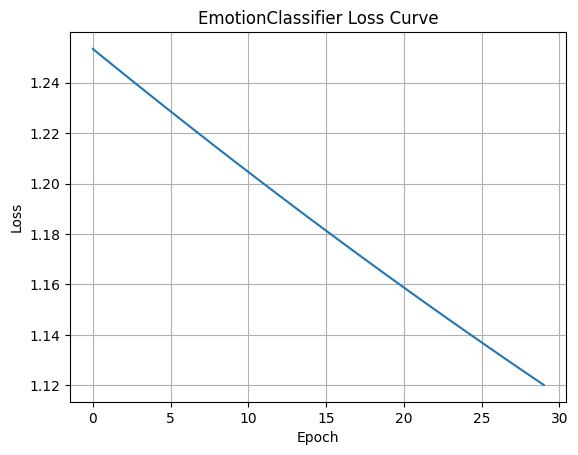

[OK] PolicyNet 建立成功
=== 訓練 DQN 中... ===
[DQN] Episode 0, Loss = 0.1650
[DQN] Episode 30, Loss = 0.5626
[DQN] Episode 60, Loss = 1.1541
[DQN] Episode 90, Loss = 1.1082
[DQN] Episode 120, Loss = 0.9375
[DQN] Episode 150, Loss = 1.0344


/tmp/ipython-input-3667537769.py:140: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = mse(q_pred, torch.tensor(target))


[DQN] Episode 180, Loss = 0.9833
[OK] DQN 訓練完成

====== End-to-End Demo ======
Input x: 1.0188182592391968
Predicted Emotion: 0
Selected Strategy: 0
Strategy Meaning: 安撫
====== Demo Finish ======


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt

# =========================================================
# 1. 產生一維輸入的 Toy Dataset
# =========================================================
def generate_sample():
    x = torch.randn(1) * 0.8  # 一維情緒訊號
    if x < -0.3:
        label = 2      # 負向
    elif x > 0.3:
        label = 1      # 焦慮
    else:
        label = 0      # 平靜
    return x, label

N = 500
X, Y = [], []
for _ in range(N):
    x, y = generate_sample()
    X.append(x)
    Y.append(y)

X = torch.stack(X)
Y = torch.tensor(Y)

print("[OK] 一維資料集建立成功")

# =========================================================
# 2. EmotionClassifier (分類器)
# =========================================================
class EmotionClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 3)
        )
    def forward(self, x):
        return self.net(x)

emotion_model = EmotionClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(emotion_model.parameters(), lr=1e-3)

print("[OK] EmotionClassifier 建立成功")

# =========================================================
# 3. 訓練分類器 & 記錄 Loss
# =========================================================
clf_losses = []

print("=== 訓練情緒分類器中... ===")
for epoch in range(30):
    optimizer.zero_grad()
    pred = emotion_model(X)
    loss = criterion(pred, Y)
    loss.backward()
    optimizer.step()

    clf_losses.append(loss.item())

    if epoch % 5 == 0:
        print(f"[Classifier] Epoch {epoch}, Loss = {loss.item():.4f}")

print("[OK] EmotionClassifier 訓練完成")

# =========================================================
# 4. 繪製 Loss Curve（你要求的功能 3）
# =========================================================
plt.plot(clf_losses)
plt.title("EmotionClassifier Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# =========================================================
# 5. DQN Policy Network (策略網路)
# =========================================================
A = 4  # 四種策略

def user_response(state, action):
    if action == state:
        reward = +1
        next_state = max(0, state - 1)
    else:
        reward = -1
        next_state = min(2, state + 1)

    if random.random() < 0.1:
        reward = -2

    return next_state, reward

class PolicyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, A)
        )
    def forward(self, s):
        return self.fc(s)

policy = PolicyNet()
opt = optim.Adam(policy.parameters(), lr=1e-3)
mse = nn.MSELoss()

def to_tensor(x):
    return torch.tensor([[x]], dtype=torch.float32)

print("[OK] PolicyNet 建立成功")

# =========================================================
# 6. 訓練 DQN 策略網路（RL）
# =========================================================
print("=== 訓練 DQN 中... ===")

for episode in range(200):
    state = random.randint(0, 2)

    if random.random() < 0.2:
        action = random.randint(0, A-1)
    else:
        action = torch.argmax(policy(to_tensor(state))).item()

    next_state, reward = user_response(state, action)

    q_next = policy(to_tensor(next_state)).detach()
    target = reward + 0.9 * torch.max(q_next)

    q_pred = policy(to_tensor(state))[0, action]

    loss = mse(q_pred, torch.tensor(target))
    opt.zero_grad()
    loss.backward()
    opt.step()

    if episode % 30 == 0:
        print(f"[DQN] Episode {episode}, Loss = {loss.item():.4f}")

print("[OK] DQN 訓練完成")

# =========================================================
# 7. End-to-End Demo（你要求的功能 1）
# =========================================================
print("\n====== End-to-End Demo ======")

sample_x, _ = generate_sample()
emotion_logits = emotion_model(sample_x)
emotion = torch.argmax(emotion_logits).item()

q_values = policy(to_tensor(emotion))
action = torch.argmax(q_values).item()

strategy_list = ["安撫", "諮詢", "引導", "支持"]

print("Input x:", sample_x.item())
print("Predicted Emotion:", emotion)
print("Selected Strategy:", action)
print("Strategy Meaning:", strategy_list[action])
print("====== Demo Finish ======")
